Source: https://www.geeksforgeeks.org/fake-news-detection-using-machine-learning/

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as pl
import os

In [199]:
df_src = pd.read_csv(pl.Path(os.path.abspath('')).parent.resolve() / "data_files/news_sample.csv")
df = df_src.copy()
df = df.drop(["id", "Unnamed: 0","domain", "url", "scraped_at", "inserted_at", "updated_at", "title", "authors", "keywords", "meta_keywords", "meta_description", "tags", "summary"], axis = 1)


In [200]:
df.type.value_counts()

fake          155
conspiracy     31
political      23
unreliable      6
bias            6
junksci         6
unknown         6
reliable        3
clickbait       1
hate            1
Name: type, dtype: int64

In [201]:
fake = "fake"
real = "political"
df = df[(df.type == fake) | (df.type == real)]
df.isnull().sum()

type       0
content    0
dtype: int64

In [202]:
# Shuffling
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(["index"], axis=1, inplace=True)

<Axes: xlabel='type', ylabel='count'>

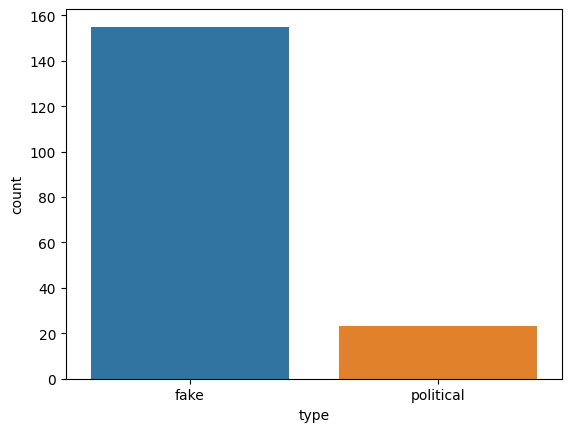

In [203]:
sns.countplot(data=df,
              x='type',
              order=df['type'].value_counts().index)

### Preprocessing and analysis of News column

In [204]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\45609\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\45609\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [205]:
def preprocess_text(text_data):
    preprocessed_text = []
      
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed_text

In [206]:
preprocessed_review = preprocess_text(df['content'].values)
df['content'] = preprocessed_review

100%|██████████| 178/178 [00:31<00:00,  5.68it/s]


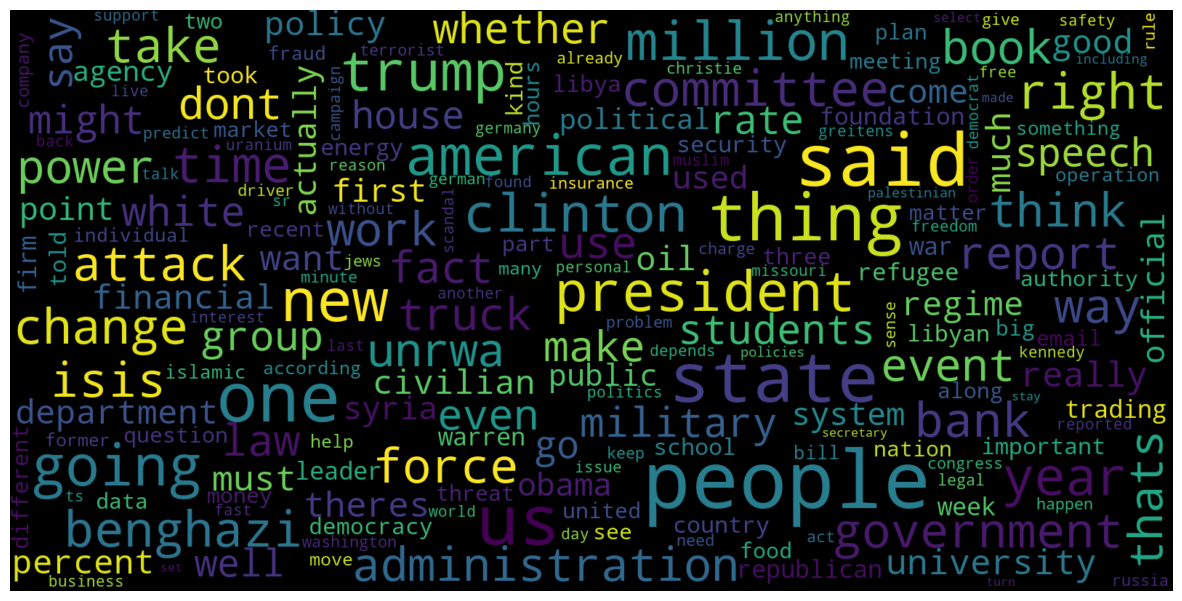

In [207]:
# Real
consolidated = ' '.join(
    word for word in df['content'][df['type'] == real].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

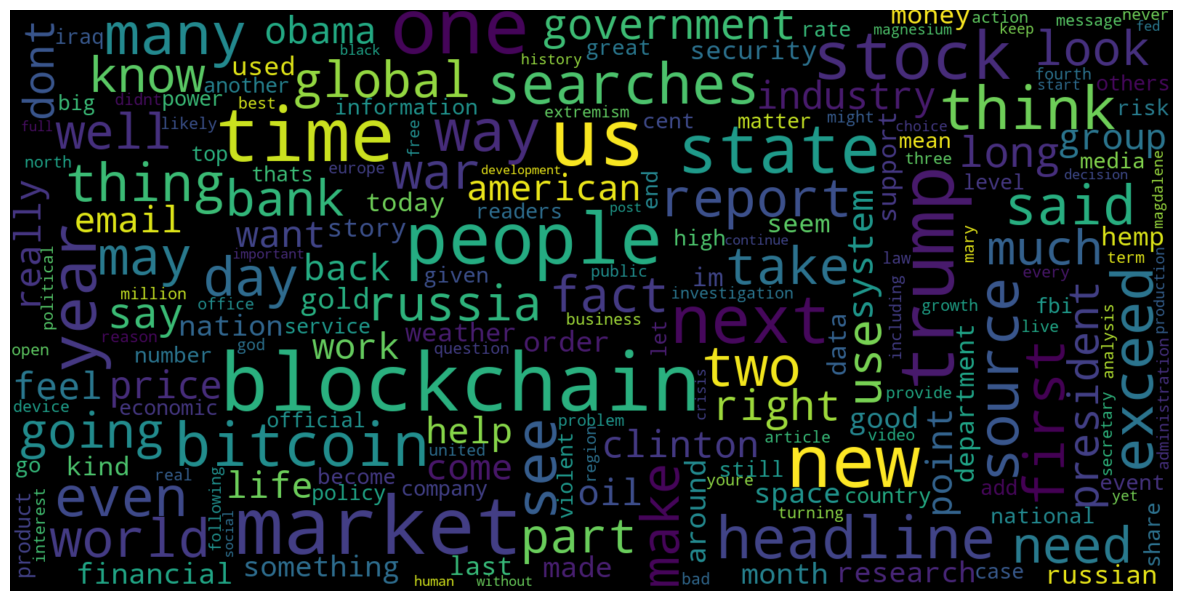

In [208]:
# Fake
consolidated = ' '.join(
    word for word in df['content'][df['type'] == fake].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

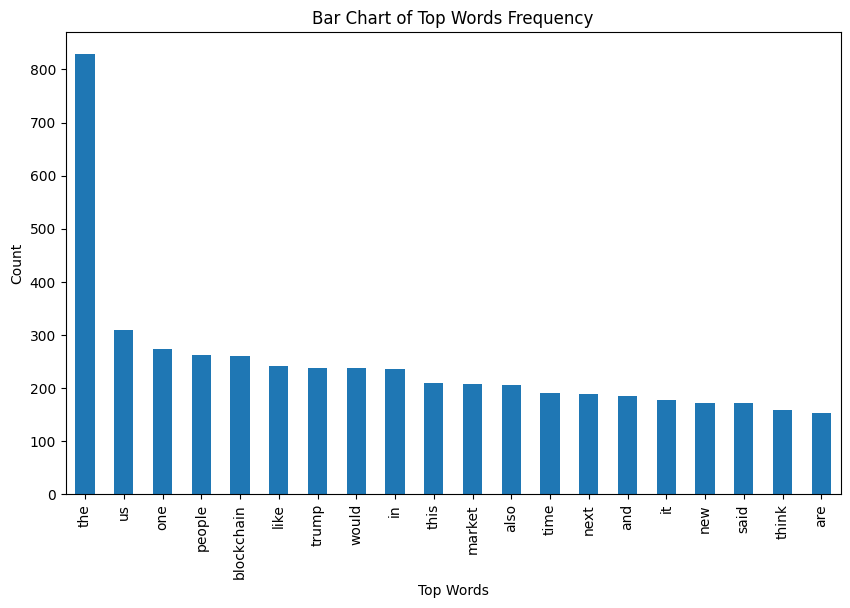

In [209]:
from sklearn.feature_extraction.text import CountVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(df['content'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)

### Converting text into Vectors
Before converting the data into vectors, split it into train and test.

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
  
x_train, x_test, y_train, y_test = train_test_split(df['content'], 
                                                    df['type'], 
                                                    test_size=0.25)

In [211]:
from sklearn.feature_extraction.text import TfidfVectorizer
  
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

### Model training, Evaluation, and Prediction
Now, the dataset is ready to train the model.

For training we will use Logistic Regression and evaluate the prediction accuracy using accuracy_score.

In [213]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9022556390977443
0.7777777777777778


Let’s train with Decision Tree Classifier. 

In [214]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))


1.0
0.8444444444444444


The confusion matrix for Decision Tree Classifier can be implemented with the code below.

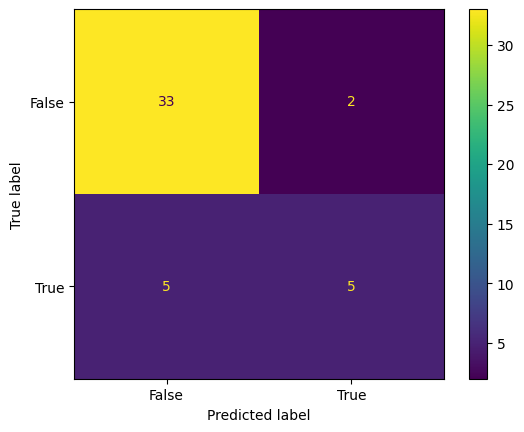

In [215]:
# Confusion matrix of Results from Decision Tree classification
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, model.predict(x_test))
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()